In [1]:
#import required libraries
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import skexplain

(CVXPY) Mar 06 09:38:03 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 06 09:38:03 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
#load in data
data = pd.read_csv("rolling_average_differentials.csv")

#randomly sample an outcome from each game
data = data.groupby("game_id").sample(n=1, random_state=84)

#filter for only stats variables and the target variable
data = data.iloc[:, 4:]
data.head()

,scores,passing_yards,rushing_yards,passing_touchdown,rushing_touchdown,highest_yac,time_to_throw,sacks_taken,fourth_down_converted,third_down_converted,...,wpa,qb_hits,tackles_for_loss,punts_inside_20,punt_attempts,punts_blocked,return_yards,drives,longest_drive,win
1,0.8,66.2,-59.2,1.4,-0.4,4.0,0.163798,-1.8,0.4,-0.4,...,-0.183276,1.0,1.8,-0.6,-1.6,0.2,0.6,-1.6,0.4,0
2,-4.0,-25.0,34.2,-1.2,0.8,-2.2,-0.220806,-0.8,-0.4,0.2,...,0.219131,-2.8,-0.6,0.8,0.2,0.0,4.4,1.2,-2.2,1
4,15.6,-17.2,131.0,1.0,1.2,-7.0,0.230001,-1.0,1.0,0.4,...,0.226656,-1.6,-0.4,0.4,-2.0,0.0,-8.6,-0.4,1.2,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [3]:
#test for multicollinearity using variance inflation factor
vif_scores = pd.DataFrame()
numerical_data = data.iloc[:,:-1]
vif_scores["Variable"] = numerical_data.columns

#calculate vif for each variable
vif_scores["VIF"] = [variance_inflation_factor(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_scores.sort_values("VIF", ascending=False) # vif over 10 indicates significant multicollinearity 

,Variable,VIF
0,scores,16.378876
16,epa,13.025336
23,punt_attempts,7.081999
3,passing_touchdown,6.536280
26,drives,6.474562
1,passing_yards,4.424097
4,rushing_touchdown,4.200457
15,penalty_yards,3.940018
14,penalties,3.803242
19,wpa,3.651120


In [4]:
#reset vif dataframe
vif_scores = pd.DataFrame()

#remove highly collinear variables one at a time based on vif results
numerical_data = numerical_data.drop(columns=["scores", "epa", "wpa"])

#recalculate vif after dropping multicollinear variables
vif_scores["Variable"] = numerical_data.columns
vif_scores["VIF"] = [variance_inflation_factor(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_scores.sort_values("VIF", ascending=False)

,Variable,VIF
20,punt_attempts,4.885751
14,penalty_yards,3.888042
13,penalties,3.783559
0,passing_yards,3.698457
23,drives,3.228858
1,rushing_yards,2.748074
2,passing_touchdown,2.712846
6,sacks_taken,2.231615
17,qb_hits,2.194636
11,fumbles_forced,2.095280


In [5]:
#drop the selected multicollinear features from the original dataset
data.drop(columns=["scores", "epa", "wpa"], inplace=True)

#split data into training and testing
train, test = train_test_split(data, test_size=0.20, random_state=84)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [6]:
#separate target and feature variables for training set
colnames = list(train.columns[:-1])
X_train = train[colnames].copy()
y_train = train["win"]

In [7]:
#bin the feature variables and fit on the training set
bin_proc = BinningProcess(colnames)
bin_proc.fit(X_train, y_train)

#replace original variables with binned values
X_train_binned = bin_proc.transform(X_train, metric="indices")
X_train[colnames] = X_train_binned

In [8]:
#check for separation concerns

#loop through each predictor column
for col in X_train:
    #create contingency table
    tbl = pd.crosstab(X_train[col], y_train)
    
    if np.any(tbl.values == 0):
        #print table if separation concerns
        print(tbl, "\n-------------------\n")

In [9]:
#checks for default number of variables to consider at each split
mtry = np.sqrt(len(colnames))
print(mtry, "\n")

#define the hyperparameter grid for random forest tuning
param_grid = {
    "bootstrap": [True],
    "max_features": [7, 8, 9, 10, 11], #mtry
    "n_estimators": [350, 450, 550, 650] #number of trees
}

#initialize a random forest classifier
rf = RandomForestClassifier(random_state=84)

#perform grid search with 10-fold cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10)


#fit the grid search model and print the best hyperparameters
grid_search.fit(X_train, y_train)
grid_search.best_params_

5.0 



{'bootstrap': True, 'max_features': 9, 'n_estimators': 450}

In [10]:
#initialize a Random Forest classifier with hyperparameters from grid search
rf_best = RandomForestClassifier(n_estimators=450,
                           max_features=9,
                           random_state=84,
                           oob_score=True)

#fit the random forest model and print the out-of-bag score
rf_best.fit(X_train, y_train)
rf_best.oob_score_

0.5917085427135679

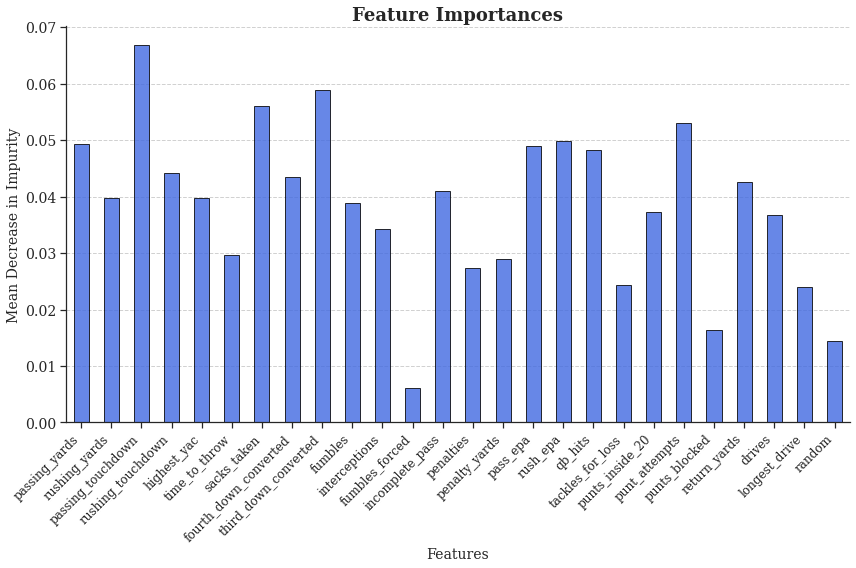

In [11]:
#add a random binary variable to a copy of the training dataset
X_train_r = X_train.copy()
X_train_r["random"] = np.random.choice([0, 1], size=len(X_train))

#initialize a random forest classifier
rf_r = RandomForestClassifier(n_estimators=450,
                                max_features=9,
                                  random_state=84,
                                  oob_score=True)

#fit the random forest model
rf_r.fit(X_train_r, y_train)

#extract feature importances from the model
forest_importances = pd.Series(rf_r.feature_importances_, index=rf_r.feature_names_in_)

#plot the feature importances to compare them visually
fig, ax = plt.subplots(figsize=(12, 8))
forest_importances.plot.bar(ax=ax, color="royalblue", edgecolor="black", alpha=0.8)
ax.set_title("Feature Importances", fontsize=18, fontweight="bold")
ax.set_ylabel("Mean Decrease in Impurity", fontsize=14)
ax.set_xlabel("Features", fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.9)
plt.xticks(rotation=45, ha="right", fontsize=12)
ax.tick_params(axis="y", labelsize=14)
fig.tight_layout()
plt.show()

PD Numerical Features: 100%|██████████████████████| 3/3 [00:05<00:00,  1.90s/it]


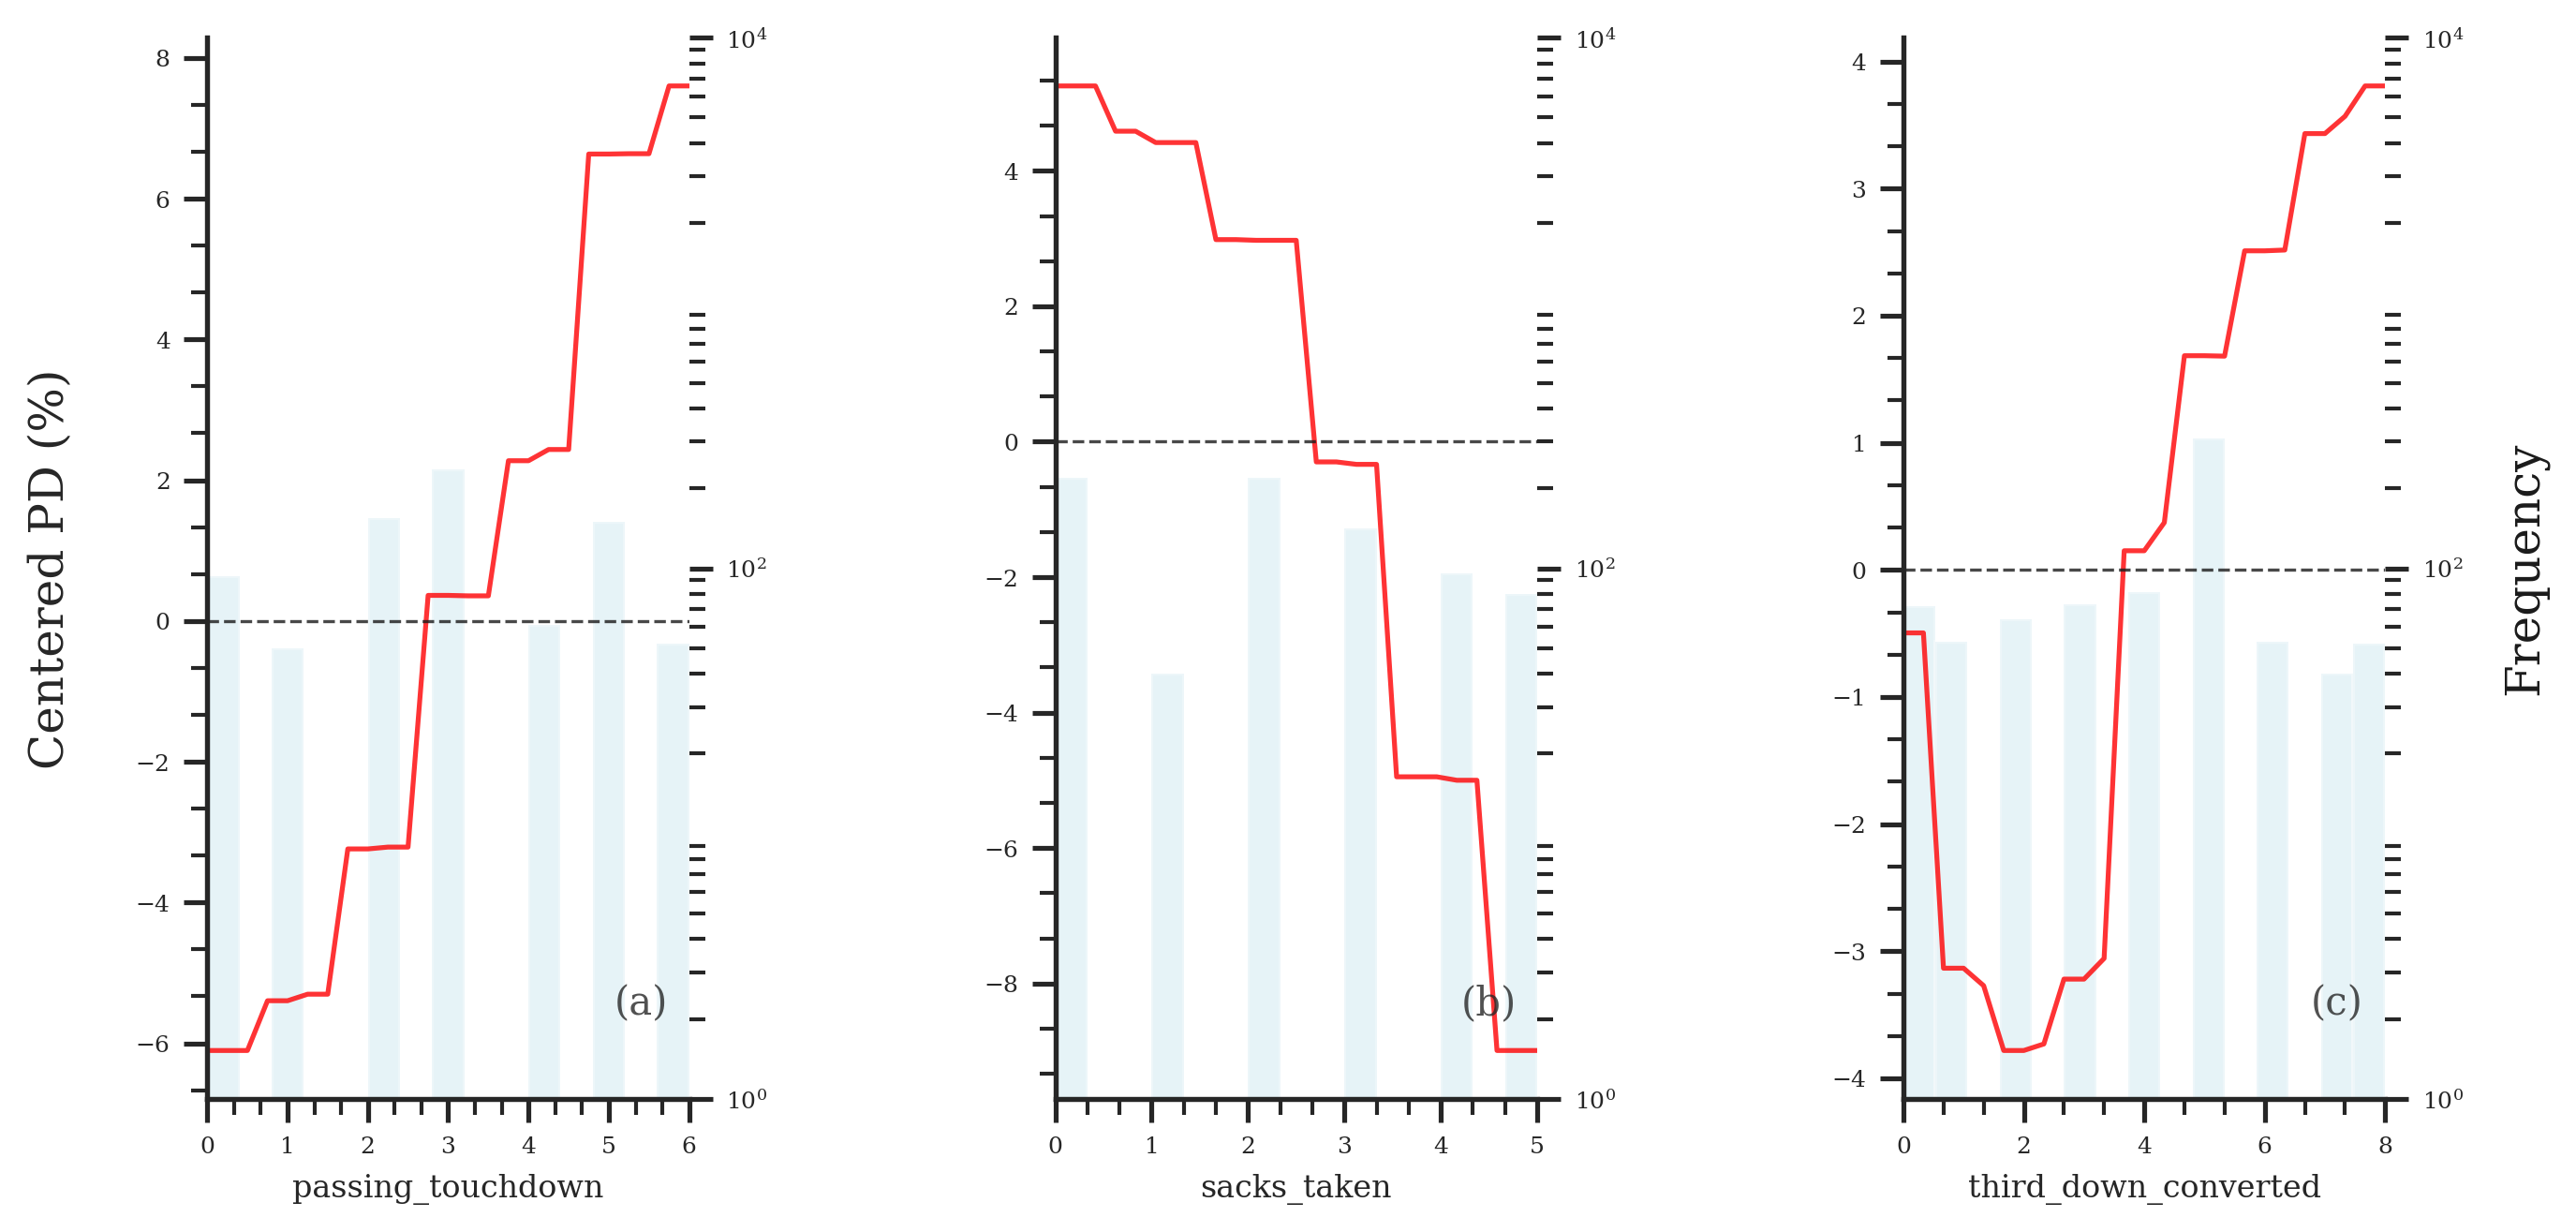

In [12]:
#initialize the explainertoolkit with random forest model
explainer = skexplain.ExplainToolkit(("Random Forest", rf_best), X=X_train, y=y_train)

#important features to analyze using partial dependence plots
imp_vars = ["passing_touchdown", "sacks_taken", "third_down_converted"]

#compute the partial dependence values for the selected features
partial_dependence = explainer.pd(features=imp_vars)

#generate and display the partial dependence plots
fig, axes = explainer.plot_pd(pd=partial_dependence, figsize=(10,5))
plt.show()

In [13]:
#separate target and feature variables for testing set
colnames = list(test.columns[:-1])
X_test = test[colnames].copy()
y_test = test["win"]

#replace original variables with binned values
X_test_binned = bin_proc.transform(X_test, metric="indices")
X_test[colnames] = X_test_binned

In [14]:
#add predicted probabilities for wins to test data
test["p_hat"] = rf_best.predict_proba(X_test)[:, 1]

#generate the false positive rate, true positive rate, and cutoffs for the roc curve
fpr, tpr, cutoffs = roc_curve(test["win"], test["p_hat"])

#create a dataframe containing the tpr, fpr, cutoffs, and youden's j statistic
data = {"TPR": tpr, "FPR": fpr, "Cut-off": cutoffs, "Youden": tpr-fpr}
youden = pd.DataFrame(data)
youden.sort_values(by="Youden", ascending=False) #highest j statistic is optimal cutoff

,TPR,FPR,Cut-off,Youden
53,0.717391,0.379630,0.497770,0.337762
55,0.728261,0.407407,0.491573,0.320853
52,0.695652,0.379630,0.502688,0.316023
51,0.684783,0.370370,0.506282,0.314412
54,0.717391,0.407407,0.493333,0.309984
...,...,...,...,...
5,0.076087,0.064815,0.700000,0.011272
1,0.010870,0.000000,0.873333,0.010870
3,0.043478,0.037037,0.744014,0.006441
0,0.000000,0.000000,1.873333,0.000000


0.6737117552334944 



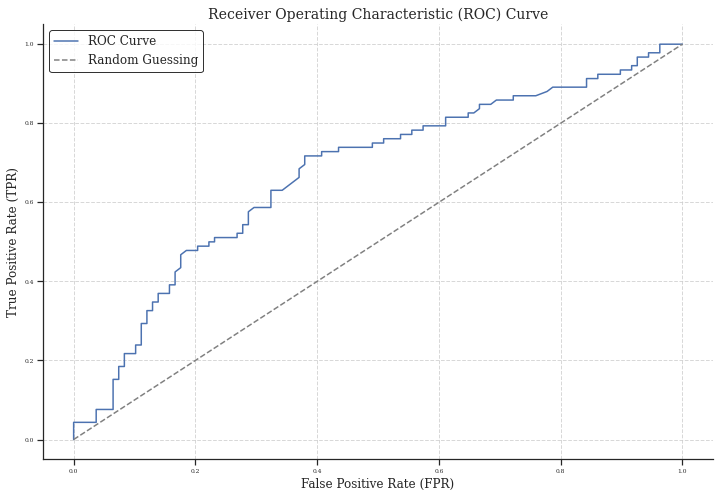

In [15]:
#print the area under the roc curve
print(auc(fpr, tpr), "\n")

#plot the roc curve
fig, ax = plt.subplots(figsize=(12, 8))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=ax, label="ROC Curve")  
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
ax.set_title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=12)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.75)
ax.legend(loc="upper left", fontsize=12, frameon=True, facecolor="white", edgecolor="black")
plt.show()

In [16]:
test['pred'] = test['p_hat'].map(lambda x: 1 if x >= 0.497770 else 0)
conf_mat = pd.crosstab(test['win'], test['pred'])
conf_mat

pred,0,1
win,,
0,67,41
1,26,66


In [17]:
metrics = {"tpr" : conf_mat.iloc[1,1] / conf_mat.iloc[1,:].sum(),
           "tnr" : conf_mat.iloc[0,0] / conf_mat.iloc[0,:].sum(),
           "fpr" : conf_mat.iloc[0,1] / conf_mat.iloc[0,:].sum(),
           "fnr" : conf_mat.iloc[1,0] / conf_mat.iloc[1,:].sum(),
           "precision" : conf_mat.iloc[1,1] / conf_mat.iloc[:,1].sum(),
           "recall" : conf_mat.iloc[1,1] / conf_mat.iloc[1,:].sum(),
           "accuracy" : (conf_mat.iloc[1,1] + conf_mat.iloc[0,0]) / conf_mat.sum().sum(),
           "error" : (conf_mat.iloc[0,1] + conf_mat.iloc[1,0]) / conf_mat.sum().sum()}

pd.DataFrame([metrics])

,tpr,tnr,fpr,fnr,precision,recall,accuracy,error
0,0.717391,0.62037,0.37963,0.282609,0.616822,0.717391,0.665,0.335
